In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller as adf
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import pydotplus as pydot
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import StandardScaler

In [2]:
# load the data from the csv file and use the date as the index
data = pd.read_csv('InvestmentReplica.csv', header=0)
data = data.set_index('Date')
data.index = pd.to_datetime(data.index, dayfirst=True)
# divide it into indexes and futures
futures_list = ['RX1','TY1','GC1','CO1','ES1','VG1',
    'NQ1','LLL1','TP1','DU1', 'TU2' ]
indexes_list = ['MXWO','MXWD','LEGATRUU','HFRXGL']
indexes = data[indexes_list]
futures = data[futures_list]

# Data exploration
## Indexes data exploration

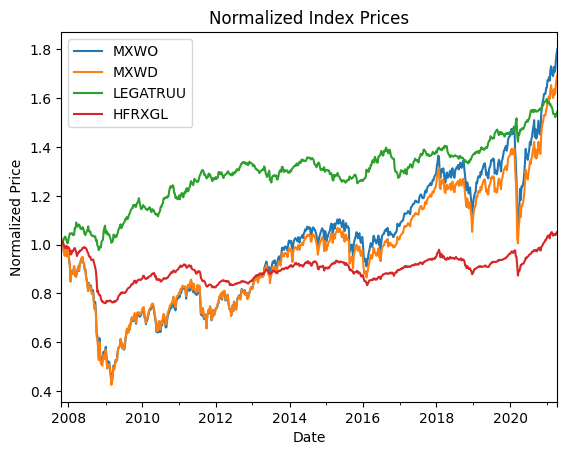

In [3]:
# plot the indexes
indexes_norm = indexes.div(indexes.iloc[0])
indexes_plot = indexes_norm.plot()
indexes_plot.set_ylabel('Normalized Price')
indexes_plot.set_xlabel('Date')
indexes_plot.set_title('Normalized Index Prices')
plt.show()

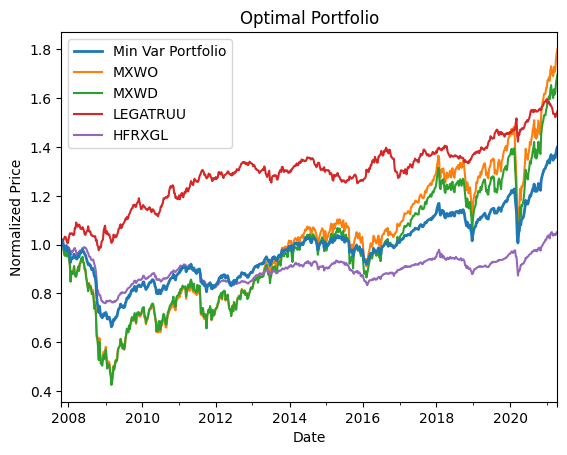

Optimal Weights:
[ 0.51298836 -0.5711139   0.43728726  0.62083829]
Expected Return:
0.0005389851958403927
Standard Deviation:
0.01099364337454438


In [4]:
# define the expected returns, their covariance matrix and the fixed return
# we want to achieve
returns = indexes.pct_change().dropna()
mu = returns.mean()
Sigma = returns.cov()
Sigma_inv = np.linalg.inv(Sigma)
r = 0.3
ones = np.ones(len(mu))

# calculate the optimal weights
w = Sigma_inv.dot(mu-r*ones)/(ones.T.dot(Sigma_inv).dot(mu-r*ones))

# define the portfolio through the optimal weights
portfolio = indexes.dot(w)
portfolio.name = 'Min Var Portfolio'

portfolio_norm = portfolio.div(portfolio.iloc[0])
portfolio_plot = portfolio_norm.plot(zorder=1, lw=2)
indexes_norm.plot(ax=portfolio_plot, zorder=0)
portfolio_plot.set_ylabel('Normalized Price')
portfolio_plot.set_xlabel('Date')
portfolio_plot.set_title('Optimal Portfolio')
portfolio_plot.legend(loc='best')
plt.show()

# print the optimal weights and the expected return
print('Optimal Weights:')
print(w)
print('Expected Return:')
print(portfolio.pct_change().mean())
print('Standard Deviation:')
print(portfolio.pct_change().std())

## Futures data exploration

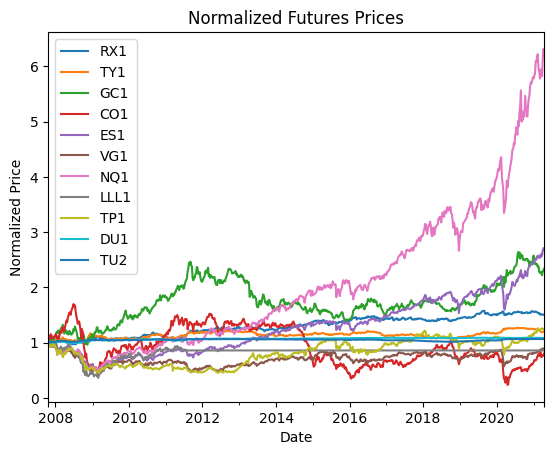

In [5]:
# graph the futures normalized prices
futures_norm = futures.div(futures.iloc[0])
futures_plot = futures_norm.plot()
futures_plot.set_ylabel('Normalized Price')
futures_plot.set_xlabel('Date')
futures_plot.set_title('Normalized Futures Prices')
plt.show()

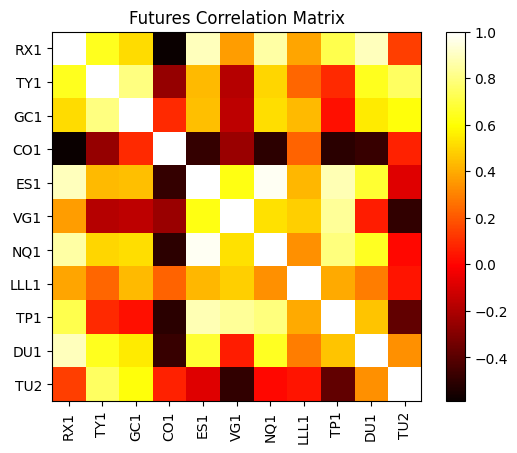

In [6]:
# create the correlation matrix heatmap
futures_corr = futures_norm.corr()
futures_corr_plot = plt.imshow(futures_corr, cmap='hot',
    interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(futures_corr)), futures_corr.columns, rotation=90)
plt.yticks(range(len(futures_corr)), futures_corr.columns)
plt.title('Futures Correlation Matrix')
plt.show()

# Data Stabilization
## Original target data

In [7]:
# perform the adf test on the target data
adf_result = adf(portfolio)
print(f""" -- ADF Test --
ADF Statistic: {adf_result[0]}
p-value: {adf_result[1]}
Critical Values:
    1%: {adf_result[4]['1%']}
    5%: {adf_result[4]['5%']}
    10%: {adf_result[4]['10%']}
{ ' The time series is Stationary' if adf_result[0] < adf_result[4]['5%']
    else 'The time series is not Stationary'}
(with 95% confidence)
""")

 -- ADF Test --
ADF Statistic: 0.6445228965397661
p-value: 0.9886631474209259
Critical Values:
    1%: -3.4396861854831964
    5%: -2.865660062273053
    10%: -2.5689640195342456
The time series is not Stationary
(with 95% confidence)



## First differences of the target

In [8]:
# get the returns of the portfolio
portfolio_diff = portfolio.diff().dropna()

# perform the adf test on the returns of the portfolio
adf_result = adf(portfolio_diff)
print(f""" -- ADF Test --
ADF Statistic: {adf_result[0]}
p-value: {adf_result[1]}
Critical Values:
    1%: {adf_result[4]['1%']}
    5%: {adf_result[4]['5%']}
    10%: {adf_result[4]['10%']}
{ ' The time series is Stationary' if adf_result[0] < adf_result[4]['5%']
    else 'The time series is not Stationary'}
(with 95% confidence)
""")

 -- ADF Test --
ADF Statistic: -22.339688012330694
p-value: 0.0
Critical Values:
    1%: -3.4396861854831964
    5%: -2.865660062273053
    10%: -2.5689640195342456
 The time series is Stationary
(with 95% confidence)



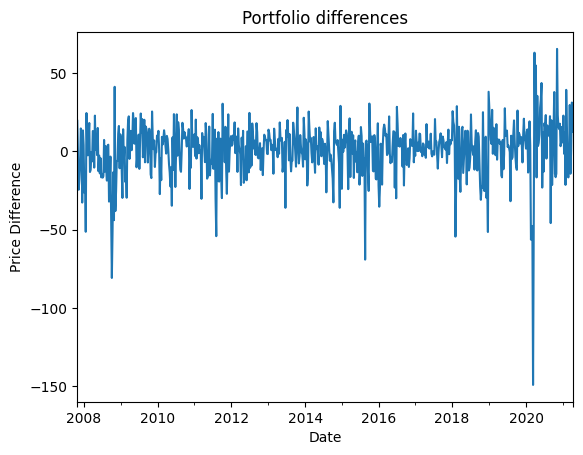

In [9]:
# graph the portfolio differences
portfolio_diff_plot = portfolio_diff.plot()
portfolio_diff_plot.set_ylabel('Price Difference')
portfolio_diff_plot.set_xlabel('Date')
portfolio_diff_plot.set_title('Portfolio differences')
plt.show()

As we can see this looks much more like a stationary time series.
Therefore we will use the first differences in all of our models.  
We will need to then reverse the first differences when we want to make
predictions.
## Original futures data

In [10]:
# perform the adf test on the futures data
for future in futures:
    adf_result = adf(futures[future])
    print(
        f"{future:>4} -- {adf_result[0]:>5.2f}, {adf_result[1]:.2f} -- " \
        f"""{
            'Stationary' if adf_result[0] < adf_result[4]['5%']
            else 'Not Stationary'
        }"""
    )

 RX1 -- -1.26, 0.65 -- Not Stationary
 TY1 -- -2.66, 0.08 -- Not Stationary
 GC1 -- -1.60, 0.48 -- Not Stationary
 CO1 -- -2.47, 0.12 -- Not Stationary
 ES1 --  2.06, 1.00 -- Not Stationary
 VG1 -- -2.95, 0.04 -- Stationary
 NQ1 --  3.66, 1.00 -- Not Stationary
LLL1 -- -3.40, 0.01 -- Stationary
 TP1 -- -0.99, 0.76 -- Not Stationary
 DU1 -- -2.28, 0.18 -- Not Stationary
 TU2 -- -1.94, 0.32 -- Not Stationary


## First differences of the futures
Since we have used the first differences of the target data, we will also try
to use the first differences of the futures data.

In [11]:
# get the returns of the futures
futures_diff = futures.diff().dropna()

# perform the adf test on the returns of the futures
for future in futures_diff:
    adf_result = adf(futures_diff[future])
    print(
        f"{future:>4} -- {adf_result[0]:>6.2f}, {adf_result[1]:.2f} -- " \
        f"""{
            'Stationary' if adf_result[0] < adf_result[4]['5%']
            else 'Not Stationary'
        }"""
    )

 RX1 -- -20.99, 0.00 -- Stationary
 TY1 -- -27.35, 0.00 -- Stationary
 GC1 -- -29.09, 0.00 -- Stationary
 CO1 --  -8.52, 0.00 -- Stationary
 ES1 --  -8.98, 0.00 -- Stationary
 VG1 -- -15.18, 0.00 -- Stationary
 NQ1 --  -8.70, 0.00 -- Stationary
LLL1 --  -4.50, 0.00 -- Stationary
 TP1 -- -28.15, 0.00 -- Stationary
 DU1 --  -6.58, 0.00 -- Stationary
 TU2 --  -6.55, 0.00 -- Stationary


As we can see, the first differences of the futures is also stationary and we
can use it in our models to try and predict the target.
# Neural network models
We will test a few different types of neural networks to see which one performs
best.  
By using Neural Networks we aim to capture long-term, non linear relationships
between the target and the futures or rather, we aim to capture the non-linear
relationships between the futures and the weights of a replicating portfolio.  
This poses a challenge since we must train the neural network to predict the
weights of the replicating portfolio, not the target itself.  
We are forcing back linearity into the problem by using the replicating
portfolio weights as the target. 
## Simple RNN
First of all we try to get our hands dirty and find out if there actually is a
relationship between the futures and the weights of the replicating portfolio.
Since we are looking for a long-term relationship, we will use a Recurrent
Neural Network (RNN).
### Data preparation
We create a function to prepare the data for the RNN. The function takes in the
dataframes, the number of lags to use and split for training and testing.
First it normalizes the data by using z-scoring, then it creates sliding windows
of the data with the specified number of lags, finally it splits the data into
training and testing sets.

In [12]:
# model parameters
lookback = 30
train_pct = 0.8

# convert the data into numpy arrays
x, y = futures_diff.values, portfolio_diff.values

# scale the data using a z-score transformation
scaler = StandardScaler()
x = scaler.fit_transform(x)
y = scaler.fit_transform(y.reshape(-1, 1)).reshape(-1) # monodimensional y

num_features, num_obs_used = x.shape[1], x.shape[0] - lookback + 1
# create the x and y data by deleting the first lookback-1 observations
x_data, y_data = x[lookback-1:, :], y[lookback-1:]
sw_data = np.zeros((num_obs_used, lookback, num_features))

# create the sliding window data
for i in range(num_obs_used):
    sw_data[i, :, :] = x[i:i+lookback, :]

# split the data into training and test sets
split_index = int(train_pct * num_obs_used)
sw_train, sw_test = sw_data[:split_index, :, :], sw_data[split_index:, :, :]
y_train, y_test= y_data[:split_index], y_data[split_index:]
x_train, x_test = x_data[:split_index, :], x_data[split_index:, :]

# show the shape of the data
print(f"""X_train shape: {x_train.shape}
SW_train shape: {sw_train.shape}
y_train shape: {y_train.shape}
X_test shape: {x_test.shape}
y_test shape: {y_test.shape}
SW_test shape: {sw_test.shape}""")

X_train shape: (540, 11)
SW_train shape: (540, 30, 11)
y_train shape: (540,)
X_test shape: (135, 11)
y_test shape: (135,)
SW_test shape: (135, 30, 11)


**Note:** Here we use z-scoring to rescale our data and make it nicer for our
neural networks to work with. One caveat is that by default both RNN's and
LSTM's use the tanh activation function, which has a range of (-1, 1). Thus, we
should rescale our data to be in the range of (-1, 1) or change the activation
function to something else like ReLU.
### Model architecture
We use a simple RNN with just one hidden layer with 64 units.
To actually obtain the weights of the replicating portfolio, we have to
introduce a Lambda layer to perform the dot product between the futures and the
weights, this way we can apply the mse loss function directly to the weights.


Model: "SimpleRNN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sliding_window (InputLayer)    [(None, 30, 11)]     0           []                               
                                                                                                  
 simple_rnn (SimpleRNN)         (None, 64)           4864        ['sliding_window[0][0]']         
                                                                                                  
 futures_input (InputLayer)     [(None, 11)]         0           []                               
                                                                                                  
 portofolio_weights (Dense)     (None, 11)           715         ['simple_rnn[0][0]']             
                                                                                          

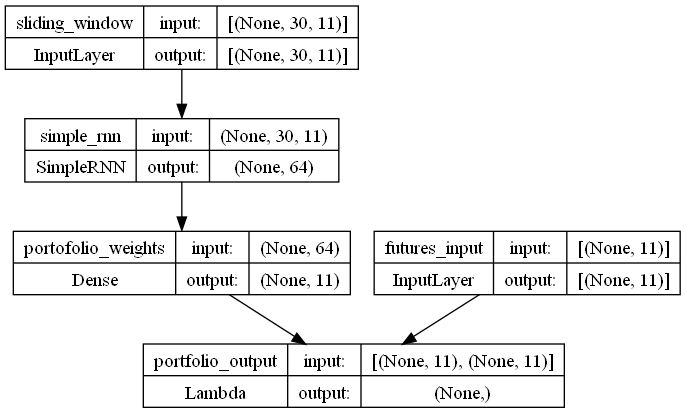

In [13]:
# parameters for the model
RNN_units = 64
# create the layers
input_layer = Input(shape=(num_features,), name='futures_input')
sw_layer = Input(shape=(lookback, num_features),
    name='sliding_window')
rnn_layer = SimpleRNN(units=RNN_units, activation='relu')(sw_layer)
weights_layer = Dense(units=num_features, activation='linear',
    name='portofolio_weights')(rnn_layer)
# perform the dot product between the weights and the reshaped input
# `bathc_dot` is used since it allows the first dimension to be variable
output_layer =  Lambda(
    lambda x: K.reshape(K.batch_dot(x[0], x[1], axes=1), (-1,)),
    name='portfolio_output')([input_layer, weights_layer])

# create the model
model = Model(inputs=[input_layer, sw_layer], outputs=output_layer,
    name='SimpleRNN')
# create a function to get the portfolio weights from the model
get_weights = K.function(
    inputs = [input_layer, sw_layer],
    outputs = [weights_layer]
)
model.summary()
plot_model(model, to_file='SimpleRNN.png', show_shapes=True,
    show_layer_names=True)

### Training and compiling

In [14]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1,
    restore_best_weights=True)

# train the model
batch_size = 32
epochs = 100
history = model.fit([x_train, sw_train], y_train, epochs=epochs,
    batch_size=batch_size, callbacks=[early_stop], validation_split=0.2,
    verbose=2)

Epoch 1/100
14/14 - 1s - loss: 4.8258 - val_loss: 1.0252 - 896ms/epoch - 64ms/step
Epoch 2/100
14/14 - 0s - loss: 2.3577 - val_loss: 0.8228 - 80ms/epoch - 6ms/step
Epoch 3/100
14/14 - 0s - loss: 1.2826 - val_loss: 0.5612 - 73ms/epoch - 5ms/step
Epoch 4/100
14/14 - 0s - loss: 1.1572 - val_loss: 0.5281 - 84ms/epoch - 6ms/step
Epoch 5/100
14/14 - 0s - loss: 1.1011 - val_loss: 0.4752 - 71ms/epoch - 5ms/step
Epoch 6/100
14/14 - 0s - loss: 0.8431 - val_loss: 0.4472 - 63ms/epoch - 5ms/step
Epoch 7/100
14/14 - 0s - loss: 1.5533 - val_loss: 0.4696 - 76ms/epoch - 5ms/step
Epoch 8/100
14/14 - 0s - loss: 0.6306 - val_loss: 0.4189 - 66ms/epoch - 5ms/step
Epoch 9/100
14/14 - 0s - loss: 0.4583 - val_loss: 0.3919 - 69ms/epoch - 5ms/step
Epoch 10/100
14/14 - 0s - loss: 0.3439 - val_loss: 0.4029 - 76ms/epoch - 5ms/step
Epoch 11/100
14/14 - 0s - loss: 0.3160 - val_loss: 0.3956 - 70ms/epoch - 5ms/step
Epoch 12/100
14/14 - 0s - loss: 0.2736 - val_loss: 0.3832 - 65ms/epoch - 5ms/step
Epoch 13/100
14/14 - 0s

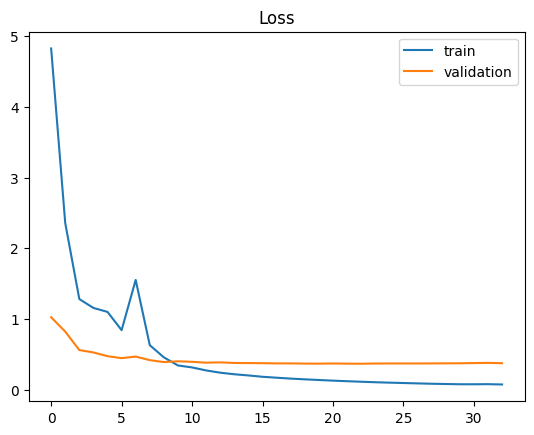

In [15]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('Loss')
plt.show()

### Testing

5/5 [==============================] - 0s 2ms/step


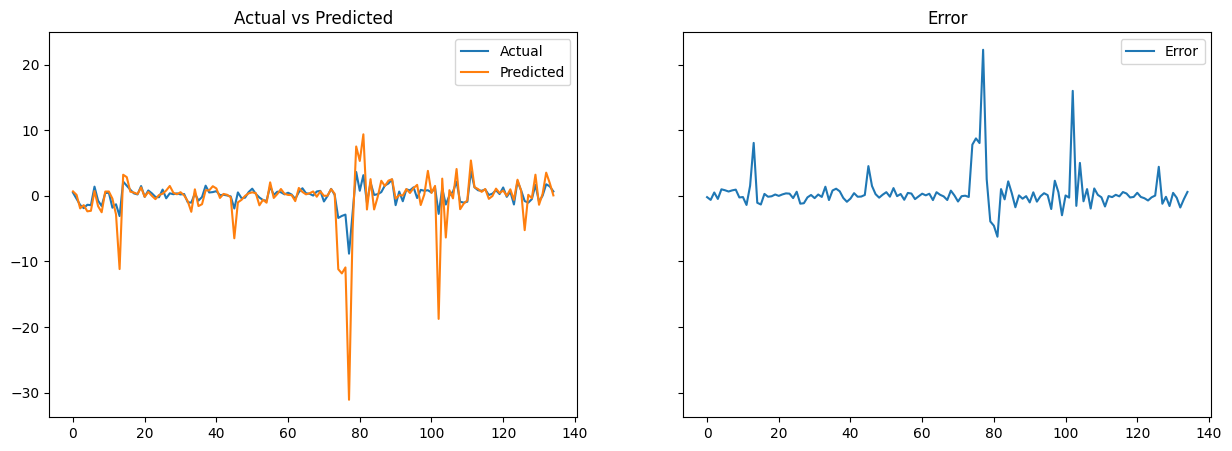

In [16]:
# make predictions on the test set
y_pred = model.predict([x_test, sw_test])

# side by side graph, predicted vs actual and the difference
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.plot(y_test, label='Actual')
ax1.plot(y_pred, label='Predicted')
ax1.legend()
ax1.set_title('Actual vs Predicted')
ax2.plot(y_test - y_pred, label='Error')
ax2.legend()
ax2.set_title('Error')
plt.show()

In [17]:
# evaluate the model
mse = model.evaluate([x_test, sw_test], y_test)
print(f'MSE: {mse:.5f}')

weights = get_weights([x_test, sw_test])[0]
print(f'Weights shape: {weights.shape}')

5/5 [==============================] - 0s 2ms/step - loss: 9.2588
MSE: 9.25878
Weights shape: (135, 11)


As we can see, even a simple RNN is able to predict the target on the test set
fairly accurately and to capture the long-term relationship between the futures
and the weights to replicate the target.  
We may now perform a grid search of the hyperparameters to find the best
combination of parameters for the RNN.  
Furthermore we may introduce a dropout layer to prevent overfitting which this 
model may be prone to, given how we have split the data.  

## LSTM RNN
We now try to improve the performance of the RNN by using a Long Short Term
Memory (LSTM) RNN.  
Since we are trying to compare the performance of the RNN and the LSTM RNN, we
will use the same architecture as before, with the only difference being the
type of RNN used.  
Let us note that here we are not giving the model a predetermined number of
lags, but rather it is learning the number of lags to use by itself.  
Thus we use the same data as before to train and test the LSTM model.
For more details read [here](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)
## Data preparation
The data has already been rescaled, we just need to split it into training and
testing sets since here we will use the whole set of observations to train and 
test the model.  
Since we want the model to remember its past states, we need make it stateful,
hence we need to fix the batch size and make all the samples divisible by the batch
size.

In [18]:
# get the quotient and remainder of the division between the number of
# observations and the batch size
quotient, remainder = x.shape[0] // batch_size, x.shape[0] % batch_size
# remove the excess observations from the data
if remainder: x, y = x[:-remainder, :], y[:-remainder] 
# split the data into training, validation and test sets
train_index = int(0.75 * quotient) * batch_size
val_index = int(0.9 * quotient) * batch_size
x_train, y_train = x[:train_index, :], y[:train_index]
x_val, y_val = x[train_index:val_index, :], y[train_index:val_index]
x_test, y_test = x[val_index:, :], y[val_index:]

# we need to reshape our input data to be of the form
# (num_samples, num_timesteps, num_features)
num_timesteps = 1
x_train = x_train.reshape(-1, num_timesteps, num_features)
x_val = x_val.reshape(-1, num_timesteps, num_features)
x_test = x_test.reshape(-1, num_timesteps, num_features)

# show the shape of the data
print(f"""X_train shape: {x_train.shape}
y_train shape: {y_train.shape}
X_val shape: {x_val.shape}
y_val shape: {y_val.shape}
X_test shape: {x_test.shape}
y_test shape: {y_test.shape}""")

X_train shape: (512, 1, 11)
y_train shape: (512,)
X_val shape: (96, 1, 11)
y_val shape: (96,)
X_test shape: (96, 1, 11)
y_test shape: (96,)


We have gained about 30 observations but more importantly here we have no
overlap between the test and training sets.  
This is quite important since LSTM are prone to overfitting and we don't want
our model to be learning from noise.
### Model architecture

Model: "LSTM"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 futures_input (InputLayer)     [(32, 1, 11)]        0           []                               
                                                                                                  
 lstm (LSTM)                    (32, 1, 64)          19456       ['futures_input[0][0]']          
                                                                                                  
 portofolio_weights (Dense)     (32, 1, 11)          715         ['lstm[0][0]']                   
                                                                                                  
 portfolio_output (Lambda)      (32,)                0           ['futures_input[0][0]',          
                                                                  'portofolio_weights[0][0]']  

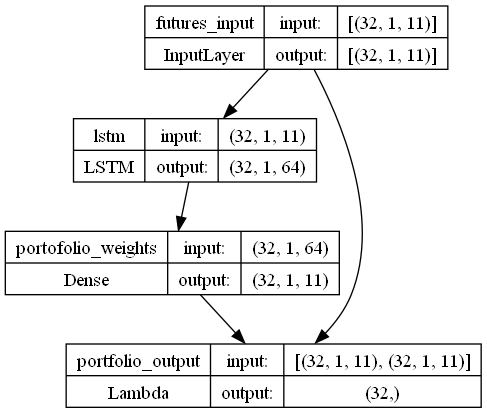

In [19]:
LSTM_units = 64

# create the LSTM layers
input_layer = Input(batch_input_shape=(batch_size, num_timesteps, num_features),
    name='futures_input')
lstm_layer = LSTM(units=LSTM_units, stateful=True,
    input_shape=(batch_size, num_features, num_timesteps),
    return_sequences=True, activation='relu')(input_layer)
weights_layer = Dense(units=num_features, activation='linear',
    name='portofolio_weights')(lstm_layer)
# perform the dot product between the weights and the reshape output to be 2D
output_layer =  Lambda(
    lambda x: K.reshape(K.batch_dot(x[0], x[1], axes=2), (-1,)),
    name='portfolio_output'
    )([input_layer, weights_layer])

# create the model
model = Model(inputs=input_layer, outputs=output_layer, name='LSTM')

model.summary()
plot_model(model, to_file='LSTM.png', show_shapes=True,
    show_layer_names=True)

### Training and compiling

In [20]:
# compile the model

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1,
    restore_best_weights=True)

# train the model
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
    validation_data=(x_val, y_val), callbacks=[early_stop], verbose=2,
    shuffle=False)

Epoch 1/100
16/16 - 1s - loss: 0.5949 - val_loss: 0.1883 - 835ms/epoch - 52ms/step
Epoch 2/100
16/16 - 0s - loss: 0.3749 - val_loss: 0.1918 - 39ms/epoch - 2ms/step
Epoch 3/100
16/16 - 0s - loss: 0.1632 - val_loss: 0.1167 - 41ms/epoch - 3ms/step
Epoch 4/100
16/16 - 0s - loss: 0.1232 - val_loss: 0.1059 - 41ms/epoch - 3ms/step
Epoch 5/100
16/16 - 0s - loss: 0.1086 - val_loss: 0.1084 - 43ms/epoch - 3ms/step
Epoch 6/100
16/16 - 0s - loss: 0.0996 - val_loss: 0.1000 - 44ms/epoch - 3ms/step
Epoch 7/100
16/16 - 0s - loss: 0.0936 - val_loss: 0.1009 - 47ms/epoch - 3ms/step
Epoch 8/100
16/16 - 0s - loss: 0.0871 - val_loss: 0.0980 - 49ms/epoch - 3ms/step
Epoch 9/100
16/16 - 0s - loss: 0.0828 - val_loss: 0.0985 - 49ms/epoch - 3ms/step
Epoch 10/100
16/16 - 0s - loss: 0.0784 - val_loss: 0.0977 - 49ms/epoch - 3ms/step
Epoch 11/100
16/16 - 0s - loss: 0.0752 - val_loss: 0.0976 - 43ms/epoch - 3ms/step
Epoch 12/100
16/16 - 0s - loss: 0.0721 - val_loss: 0.0978 - 40ms/epoch - 2ms/step
Epoch 13/100
16/16 - 0s

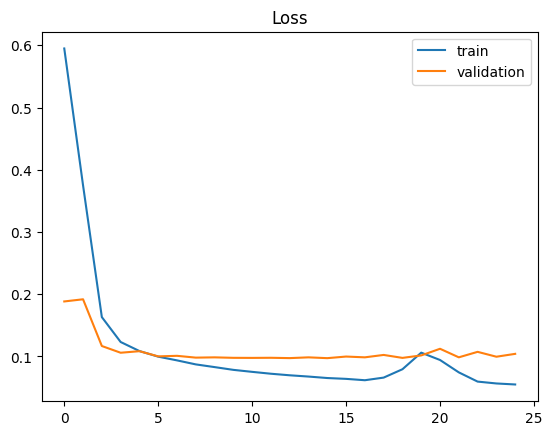

In [21]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('Loss')
plt.show()

### Testing

3/3 [==============================] - 0s 2ms/step


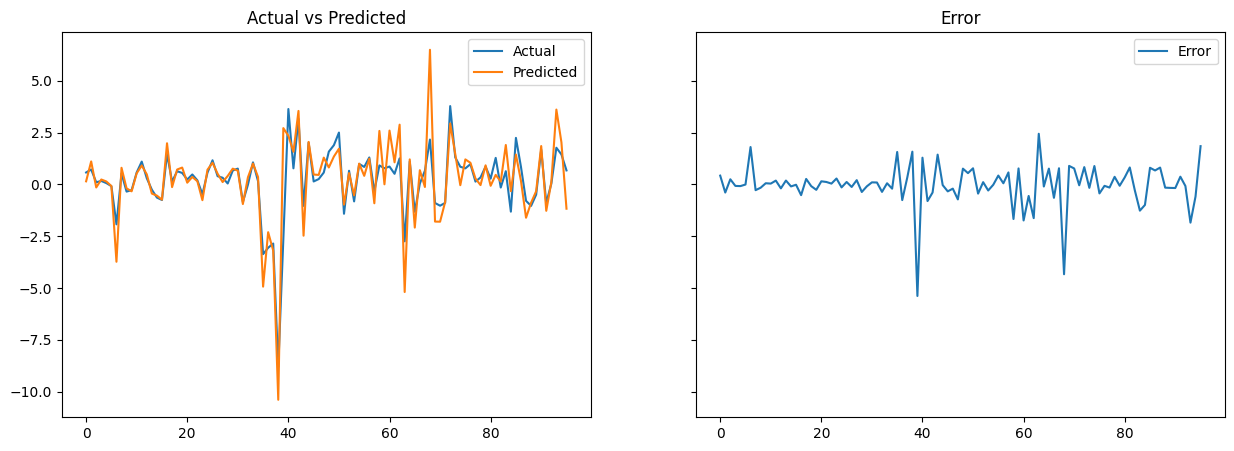

In [22]:
y_pred = model.predict(x_test)

# two side by side graph, one for the actual vs predicted and one for the error
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.plot(y_test, label='Actual')
ax1.plot(y_pred, label='Predicted')
ax1.legend()
ax1.set_title('Actual vs Predicted')
ax2.plot(y_test - y_pred, label='Error')
ax2.legend()
ax2.set_title('Error')
plt.show()

In [23]:
# evaluate the model
mse = model.evaluate(x_test, y_test)
print(f'MSE: {mse:.5f}')

3/3 [==============================] - 0s 2ms/step - loss: 1.5256
MSE: 1.52560
